In [25]:
import edward as ed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import tensorflow as tf
#import tensorflow.compat.v1 as tf #for tensorflow version 2 users
#tf.disable_v2_behavior() #for tensorflow version 2 users

from edward.models import MultivariateNormalFullCovariance, Gamma, Normal, Chi2

import scipy
from tensorflow.contrib.distributions import bijectors

import matplotlib

In [2]:
from platform import python_version

print("tensorflow version: ",tf.__version__)
print("edward version: ",ed.__version__)
print("python version: ",python_version())

tensorflow version:  1.7.0
edward version:  1.3.5
python version:  3.6.4


# Derive Priors from Biological Model


In [3]:
#load input files

#expression data 
X = pd.read_pickle("data_merged.pickle")
genes = list(X)
D = X.shape[1]

#sign of overall gene-gene covariance 
S = np.sign(np.cov(X.T)).astype(np.float32)

#matrix mapping gene-gene pairs to peak indices, where applicable
g = pd.read_pickle("g_merged.pickle")
g = np.array(g).astype(np.int32)

#binarized version of g
M = pd.read_pickle("M_merged.pickle")
M = np.array(M) * S #captures signs of TF-target interactions

#cluster assignments per cell
z_inf = pd.read_pickle("z_merged.pickle").values.T[0].astype(np.int32)
K = len(set(z_inf)) #total number of clusters

In [4]:
X = X.values

Xs,Ns,zs,sigma_empirical,mu_empirical,pi = [],[],[],[],[],[]

#for each cluster, collect its expression matrix, its size, its empirical mean and covariance (for initialization and validation)
for k in range(K):
    sigma_empirical.append(np.cov(X[z_inf==k,:].T)+np.eye(D)*.00001)
    mu_empirical.append(X[z_inf==k,:].mean(0))
    Xs.append(X[z_inf==k,:])
    Ns.append(X[z_inf==k,:].shape[0])

pi = Ns/np.sum(Ns)

#proportions of each cluster
print("Cluser proportions: ", pi* 100.0)

Cluser proportions:  [27.33602562 40.6907116  18.20080769  9.80364852  3.96880657]


In [5]:
#load bulk ATAC replicates
C_1 = pd.read_pickle("rep1_merged.pickle")
C_2 = pd.read_pickle("rep2_merged.pickle")
C_3 = pd.read_pickle("rep3_merged.pickle")
C_4 = pd.read_pickle("rep4_merged.pickle")
C_5 = pd.read_pickle("rep5_merged.pickle")

In [6]:
#combine bulk ATAC-seq replicates into one matrix and re-scale
C = np.hstack([C_1,C_2,C_3,C_4,C_5])
C = np.log(C+1.0)/4.0 #re-scaling to fit covariance distribution
r = C.shape[1]

# Model Code

In [7]:
#set hyperparameters
gamma0 = float(D+1.0) #Wishart d.f.
sigma_R=.05 #standard deviation on R
sigma_C=.01 #standard deviation on C

In [8]:
#gene expression means per cluster
mu = [Normal(mu_empirical[k].astype(np.float32), np.ones(D).astype(np.float32)) for k in range(K)]

#building prior for cluster covariance matrices using biological model
#sampling p from fixed prior
p = [Gamma(np.ones(C.shape[0]).astype(np.float32)*4.5,
           np.ones(C.shape[0]).astype(np.float32)*1.0) for k in range(K)]
#sampling R from mean at p, with sign of mean given by M
R_mean1 = [tf.gather(p[k],g) for k in range(K)]
R = [Normal(tf.multiply(R_mean1[k],M.astype(np.float32)),sigma_R) for k in range(K)]
#efficiently compute cholesky factor of (R+R.T)^2
#https://scicomp.stackexchange.com/questions/27537/computing-the-cholesky-decomposition-based-of-the-qr-decomposition
psi0 = [tf.qr(tf.reshape(R[k], [D,D]) + tf.transpose(tf.reshape(R[k], [D,D])))[1] for k in range(K)]

#Bartlett decomposition for sampling Wishart, see https://projecteuclid.org/euclid.aoms/1177706379
nij = [Normal(loc=[0.0]*int(D*(D+1)/2.0),scale=[1.0]*int(D*(D+1)/2.0)) for k in range(K)]
ci = [Chi2(df = np.array([gamma0] * D).astype(np.float32) - np.array(range(D)).astype(np.float32)) for k in range(K)]
A = [tf.multiply(tf.transpose(tf.contrib.distributions.fill_triangular(nij[k],upper=True)), np.eye(D) == 0) + tf.diag(tf.sqrt(ci[k])) for k in range(K)]
sigma = [tf.divide(tf.matmul(psi0[k],A[k]),tf.sqrt(gamma0)) for k in range(K)]
sigma_full = [tf.matmul(sigma[k],sigma[k],transpose_b=True) for k in range(K)]

#for scaled Wishart, sample diagonals of scaling matrices
delta = [Normal(-4.0,100.0, sample_shape=D) for k in range(K)]
Delta = [tf.diag(tf.exp(delta[k])) for k in range(K)]
sigma_scaled = [tf.matmul(tf.matmul(Delta[k],sigma_full[k]),Delta[k]) for k in range(K)]

#gaussian model for observations
#xn = [MultivariateNormalFullCovariance(mu[i],sigma_full[i],sample_shape=Ns[i]) for i in range(K)] #without scaled Wishart
xn = [MultivariateNormalFullCovariance(mu[i],sigma_scaled[i],sample_shape=Ns[i]) for i in range(K)]

#constraining the biological prior with additional data
Cn = Normal(tf.matmul(tf.stack(p),np.array(pi).astype(np.float32).reshape(K,1), transpose_a=True),sigma_C,sample_shape=r)

#useful similar examples:
#https://discourse.edwardlib.org/t/dirichlet-process-mixture-models-dpmm-with-hierarchical-structure/232/3
#https://github.com/ecosang/misc/blob/master/mixture_gmm.ipynb

# Inference

In [9]:
prior = C[:,0][g]*M + np.abs((np.random.randn(D*D).reshape(D,D) * 3.0)) #to initialize R

#variational distributions
qnij = [Normal(loc=tf.Variable([0.0]*int(D*(D+1)/2)),
            scale=tf.nn.softplus(tf.Variable([np.log(np.exp(1)-1)]*int(D*(D+1)/2)))) for k in range(K)]

qci = [Normal(loc=tf.Variable([gamma0]*D),
            scale=tf.nn.softplus(tf.Variable([1.0]*D))) for k in range(K)]

qdelta = [Normal(loc=tf.Variable([-1.0]*D),
            scale=tf.nn.softplus(tf.Variable([.1]*D))) for k in range(K)]

qR = [Normal(loc=tf.Variable((prior).astype(np.float32)),
            scale=.0000000001) for k in range(K)]

qmu = [Normal(loc=tf.Variable(mu_empirical[k].astype(np.float32)),
            scale=tf.nn.softplus(tf.Variable([1.0]*D))) for k in range(K)]

qp = [Normal(loc=tf.Variable(C[:,0].astype(np.float32)),
            scale=tf.nn.softplus(tf.Variable([1.0]*C.shape[0]))) for k in range(K)]

In [10]:
qR_dict = {R[i]:qR[i] for i in range(K)}
qmu_dict = {mu[i]:qmu[i] for i in range(K)}
qnij_dict = {nij[i]:qnij[i] for i in range(K)}
qci_dict = {ci[i]:qci[i] for i in range(K)}
qdelta_dict = {delta[i]:qdelta[i] for i in range(K)}
qp_dict = {p[i]:qp[i] for i in range(K)}

latent_dict = {}
latent_dict.update(qR_dict)
latent_dict.update(qmu_dict)
latent_dict.update(qnij_dict)
latent_dict.update(qci_dict)
latent_dict.update(qdelta_dict)
latent_dict.update(qp_dict)

In [11]:
data_dict = {xn[i]:Xs[i] for i in range(K)}
data_dict[Cn] = np.expand_dims(C.T,axis=2)

In [12]:
#setting up inference
inference = ed.KLqp(latent_vars=latent_dict, data=data_dict)

opt = tf.train.AdamOptimizer(learning_rate=.005)

inference.initialize(optimizer=opt)

sess = ed.get_session()
tf.global_variables_initializer().run()

/Users/burdziac/homebrew/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [13]:
tol=15000 #adjust this accordingly
i=0
_=0

#setting up variables for storing over each iteration
trace = np.zeros([int(1000000/1000),D,D])
trace_qp = np.zeros([int(1000000/1000),C.shape[0]])
info_dict = inference.update()
learning_curve = [info_dict['loss']]*100
info_dict = inference.update()
learning_curve[-1] = info_dict['loss']

print(learning_curve[-10] - learning_curve[-1])

while (learning_curve[-10] - learning_curve[-1])>tol:
    info_dict = inference.update()
    _+=1
    if _%500 == 0: #record some statistics every 500 iterations
        post_mu = qmu[0].loc.eval()
    
        #sample from variational distributions and take first moment
        beta0_unconstrained = inference.transformations[ci[0]]  # transformed prior
        beta0_transform = beta0_unconstrained.bijector  # transformed prior's transformation
        qci_constrained = ed.transform(qci[0], bijectors.Invert(beta0_transform))
        post_ci = qci_constrained.sample(100).eval().mean(0)
        
        post_nij = qnij[0].loc.eval()
        post_delta = np.exp(qdelta[0].loc.eval())        
        post_R = qR[0].loc.eval()
        
        beta0_unconstrained = [inference.transformations[p[k]] for k in range(K)]  # transformed prior
        beta0_transform = [beta0_unconstrained[k].bijector for k in range(K)]  # transformed prior's transformation
        qp_constrained = [ed.transform(qp[k], bijectors.Invert(beta0_transform[k])) for k in range(K)]
        post_p = [qp_constrained[k].sample(100).eval().mean(0) for k in range(K)]
                
        #build posterior
        tmp_ = np.zeros([D,D])
        tmp_ = tf.transpose(tf.contrib.distributions.fill_triangular(post_nij,upper=True)).eval()
        post_tmp = tmp_ * (np.eye(D) == 0)
        post_A = post_tmp + np.diag(np.sqrt(post_ci))
        
        post_L = post_R + post_R.T
        tmp2 = post_L.dot(post_L)
        post_L = np.linalg.qr(post_L)[1].T
        
        tmp = post_L.dot(post_A) / np.sqrt(gamma0)
        tmp = np.diag(post_delta).dot(tmp.dot(tmp.T)).dot(np.diag(post_delta))
        
        #store for checking later
        trace[i,:,:] = np.copy(tmp)
        trace_qp[i,:] = np.copy(post_p[0])
        
        post_cov_prior = post_L.dot(post_L.T)
        
        #print various metrics
        print("Overall loss:", info_dict['loss'])
            
        print("Sigma Empirical Corr: ", np.corrcoef(sigma_empirical[0][np.eye(D)==0].flatten(),tmp[np.eye(D)==0].flatten())[0,1])
        print("Sigma Empirical Corr, Magnitude: ", np.corrcoef(np.log(np.abs(sigma_empirical[0][np.eye(D)==0].flatten())),
                                                    np.log(np.abs(tmp[np.eye(D)==0].flatten())))[0,1])
        print("Sigma Prior Corr: ", np.corrcoef(tmp2[np.eye(D)==0].flatten(),tmp[np.eye(D)==0].flatten())[0,1])
        print("Mu Empirical Corr: ", np.corrcoef(mu_empirical[0],post_mu)[0,1])
        print("Bulk ATAC Corr: ", np.corrcoef(np.stack(post_p).T.dot(pi),C[:,0])[0,1])

        print(" ")

        i+=1     
    learning_curve.append(info_dict['loss'])

122194940.0
Overall loss: 10906117000.0
Sigma Empirical Corr:  0.04161348628697084
Sigma Empirical Corr, Magnitude:  0.16686164484469704
Sigma Prior Corr:  0.0347288028998484
Mu Empirical Corr:  0.9987770406252466
Bulk ATAC Corr:  0.6378192106040389
 
Overall loss: 7981971500.0
Sigma Empirical Corr:  0.0489290108804912
Sigma Empirical Corr, Magnitude:  0.2959488550533525
Sigma Prior Corr:  0.06829844405826177
Mu Empirical Corr:  0.9992119585527771
Bulk ATAC Corr:  0.6241678974776786
 
Overall loss: 6101369300.0
Sigma Empirical Corr:  0.05315858955708422
Sigma Empirical Corr, Magnitude:  0.3831081783877787
Sigma Prior Corr:  0.09533687873329844
Mu Empirical Corr:  0.9995950133357435
Bulk ATAC Corr:  0.6553030160505096
 
Overall loss: 4793895400.0
Sigma Empirical Corr:  0.05776785667273183
Sigma Empirical Corr, Magnitude:  0.427147161116265
Sigma Prior Corr:  0.1241312654517255
Mu Empirical Corr:  0.9997724260823315
Bulk ATAC Corr:  0.6916773444101788
 
Overall loss: 3807126300.0
Sigma E

(if tolerance is met on first few iterations, re-run the notebook; this happens sometimes due to chance)

Text(0.5,1,'Trace Off-Diagonal of Covariance')

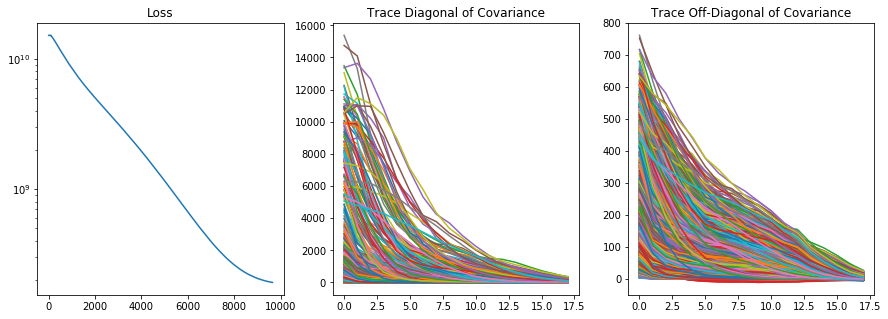

In [14]:
rcParams['figure.figsize'] = (15,5)
plt.subplot(1,3,1)
plt.semilogy(learning_curve)
plt.title("Loss")

plt.subplot(1,3,2)
plt.plot(trace[1:i,range(D),range(D)]);
plt.title("Trace Diagonal of Covariance")

plt.subplot(1,3,3)
plt.plot(trace[1:i,0,:]);
plt.plot(trace[1:i,1,:]);
plt.plot(trace[1:i,2,:]);
plt.plot(trace[1:i,3,:]);
plt.plot(trace[1:i,4,:]);
plt.title("Trace Off-Diagonal of Covariance")

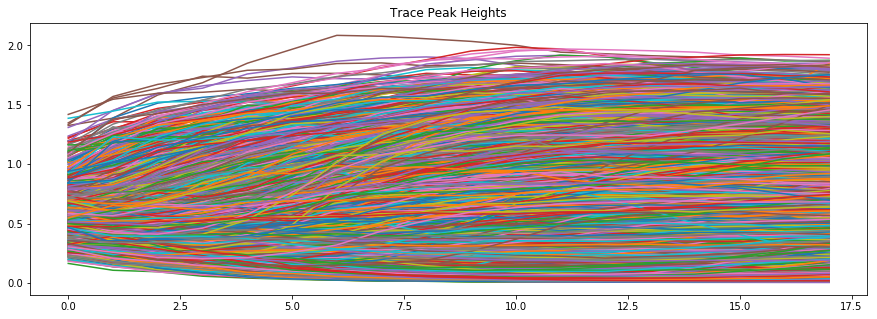

In [15]:
plt.title("Trace Peak Heights")
plt.plot(trace_qp[1:i,]);

# Criticism

In [16]:
inference.finalize()

beta0_unconstrained = [inference.transformations[ci[k]]  for k in range(K)]
beta0_transform = [beta0_unconstrained[k].bijector for k in range(K)]
qci_constrained = [ed.transform(qci[k], bijectors.Invert(beta0_transform[k])) for k in range(K)]

post_ci = [qci_constrained[k].sample(100).eval().mean(0) for k in range(K)]
post_nij = [qnij[k].loc.eval() for k in range(K)]
post_delta = [np.exp(qdelta[k].loc.eval()) for k in range(K)]

tmp_ = [np.zeros([D,D]) for k in range(K)]
for k in range(K):
    tmp_[k] = tf.transpose(tf.contrib.distributions.fill_triangular(post_nij[k],upper=True)).eval()
post_tmp = [tmp_[k] * (np.eye(D) == 0) for k in range(K)]
post_A = [post_tmp[k] + np.diag(np.sqrt(post_ci[k])) for k in range(K)]

post_R = [qR[k].loc.eval() for k in range(K)]
post_L = [post_R[k] + post_R[k].T for k in range(K)]
post_L = [np.linalg.qr(post_L[k])[1].T for k in range(K)]

tmp = [post_L[k].dot(post_A[k]) / np.sqrt(gamma0) for k in range(K)]
post_sigma_mean = [np.diag(post_delta[k]).dot(tmp[k].dot(tmp[k].T)).dot(np.diag(post_delta[k])) for k in range(K)]

post_mu = [qmu[k].loc.eval() for k in range(K)]

beta0_unconstrained2 = [inference.transformations[p[k]] for k in range(K)]  # transformed prior
beta0_transform2 = [beta0_unconstrained2[k].bijector for k in range(K)]  # transformed prior's transformation
qp_constrained = [ed.transform(qp[k], bijectors.Invert(beta0_transform2[k])) for k in range(K)]
post_p = [qp_constrained[k].sample(100).eval().mean(0) for k in range(K)]

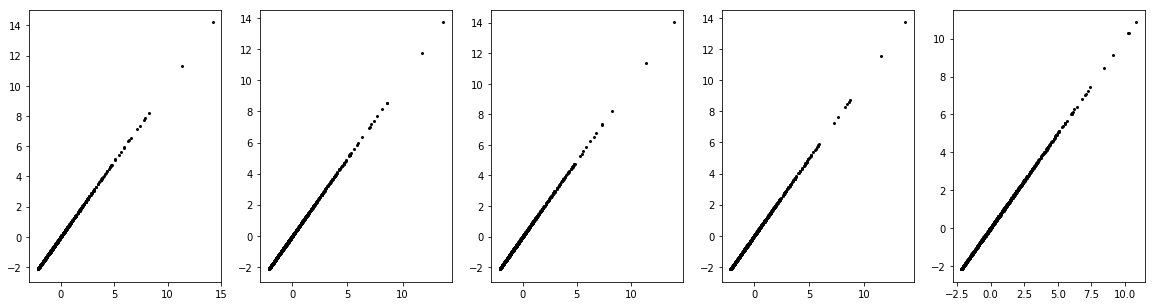

In [17]:
rcParams['figure.figsize'] = (20,5)
for k in range(K):
    plt.subplot(1,K,k+1)
    plt.scatter(post_mu[k],mu_empirical[k],s=4,c='k')

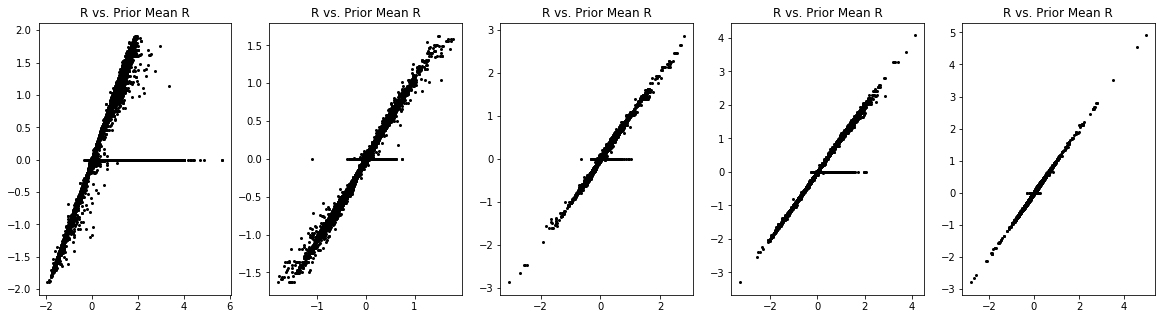

In [18]:
rcParams['figure.figsize'] = (20,5)
for k in range(K):
    plt.subplot(1,K,k+1)
    plt.scatter(post_R[k],post_p[k][g]*M,s=4,c='k')
    plt.title("R vs. Prior Mean R")

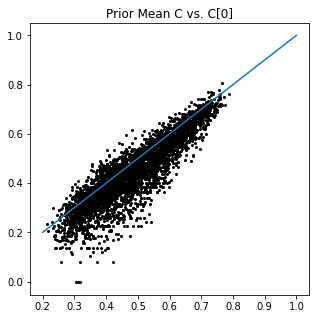

In [19]:
rcParams['figure.figsize'] = (5,5)
plt.scatter(np.stack(post_p).T.dot(pi),C[:,0],s=4,c='k')
plt.plot([.2,1],[.2,1])
plt.title("Prior Mean C vs. C[0]");

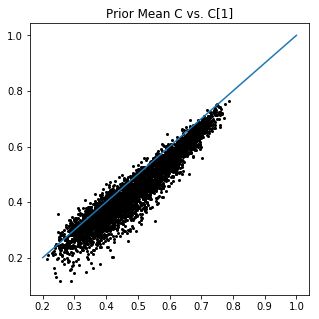

In [20]:
rcParams['figure.figsize'] = (5,5)
plt.scatter(np.stack(post_p).T.dot(pi),C[:,1],s=4,c='k')
plt.plot([.2,1],[.2,1])
plt.title("Prior Mean C vs. C[1]");

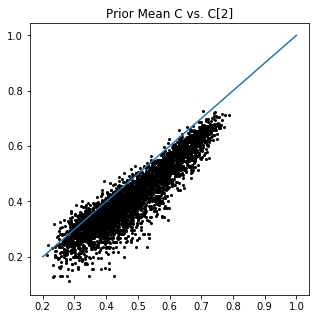

In [21]:
rcParams['figure.figsize'] = (5,5)
plt.scatter(np.stack(post_p).T.dot(pi),C[:,2],s=4,c='k')
plt.plot([.2,1],[.2,1])
plt.title("Prior Mean C vs. C[2]");

In [22]:
cov_prior = np.stack([post_L[k_check].dot(post_L[k_check].T)[np.eye(D)==0] for k_check in range(K)])
x=np.stack([np.log(np.abs(post_sigma_mean[k_check][np.eye(D)==0])) for k_check in range(K)])
y=np.log(np.abs(cov_prior))
print(np.corrcoef(x.flatten(),y.flatten())[0,1])

cov = np.stack([sigma_empirical[k_check][np.eye(D)==0] for k_check in range(K)])
y=np.log(np.abs(cov))
print(np.corrcoef(x.flatten(),y.flatten())[0,1])

0.800697264345541
0.3441288784646883


In [ ]:
#for i in range(K):
#    pd.DataFrame(post_R[i],columns=genes).to_csv("post_R_{}.csv".format(i))